## Classification

Four models were implemented for solving the *dfPoints* classification problem:
1. Logistic Regression (proposed)
2. Decision Tree
3. Random Forest
4. Support Vector Machines

In [63]:
import pandas as pd
import time

from lib import plotModule
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [64]:
dfPoints = pd.read_csv("data/df_points.txt", delimiter="\t")
dfPoints.drop('Unnamed: 0', axis=1, inplace=True)

seed = 2020
dfPoints.head(10).T

,0,1,2,3,4,5,6,7,8,9
x,326.488285,-314.287214,-328.208910,-148.658890,-467.065931,-23.863985,3.660812,405.406480,-467.877206,343.457737
y,188.988808,307.276723,181.627758,147.027947,250.467651,-44.084565,-252.599973,124.734595,-49.022047,142.910428
z,-312.205307,-179.037412,446.311062,-27.477959,-306.475330,-276.796280,-445.044071,482.317678,-340.056094,10.563133
label,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


In [65]:
X = dfPoints[['x', 'y', 'z']].copy()
y = dfPoints['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [66]:
####################### Auxiliar Functions #######################

def testClassifier(clf, grid_values):
    classifier = GridSearchCV(clf, param_grid=grid_values, scoring='recall')
    classifier.fit(X_train, y_train)
    return classifier


def calculateMetrics(name, y_pred, y_test):
    return {
        "classifier": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }


results = pd.DataFrame()
confMatrix = plotModule.ConfusionMatrix()

### Logistic Regression

Logistic regression models the probabilities for classification problems with two possible outcomes. It uses the logistic function to squeeze the output of a linear equation between 0 and 1. The logistic function can be rewritten as:

$$ \operatorname{ln}(f)=\beta_{0} + \beta_{1} * \eta$$

The coefficients (Beta values b) of the logistic regression algorithm are estimated from the training data using the maximum-likelihood estimation. The best coefficients $\beta$ would result in a model that would predict a value very close to 1 for the default class and a value very close to 0 for the other class.

In this classifier we are using two different penalty norms (L1 and L2), there are another ones available in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) page.

In [67]:
name = "Logistic Regression"

# Measure start elapsed time for later comparison
start = time.time()

# Train the classifier with grid search for penalty
grid_values = {'penalty': ['l1', 'l2']}
logistic_regression_clf = testClassifier(
    LogisticRegression(random_state=seed),
    grid_values).best_estimator_

# Predict the response using train and test data
y_pred = logistic_regression_clf.predict(X_test)
y_pred_train = logistic_regression_clf.predict(X_train)

# Measure model metrics for later comparison
end = time.time()
metrics = calculateMetrics(name, y_pred, y_test)
metrics['time'] = end - start

results = results.append(metrics, ignore_index=True)

Our Logistic Regression model presented reasonable results for the dataset classification, performing better in the detection of class 1 (correcly labeling 69% of class 1 train elements).
The similarity between the test and train confusion matrices indicates that the model has no overfitting for train dataset.

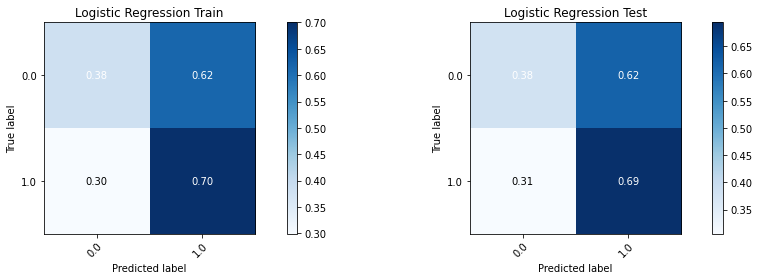

In [68]:
# Plot confusion matrix of train and test predictions
fig = plt.figure(figsize=(15, 4), facecolor='w')

confMatrix.plot(cm=confusion_matrix(y_train, y_pred_train),
                classes=y.unique(),
                title=name + ' Train',
                fig=fig,
                subplot_index=1)

confMatrix.plot(cm=confusion_matrix(y_test, y_pred),
                classes=y.unique(),
                title=name + ' Test',
                fig=fig,
                subplot_index=2)

### Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

At each iteration, all the features are considered and different split points are tried and tested using a cost function (here we are using Gini score, the default cost criterion of sklearn classifier). The split with the best cost (or lowest cost) is selected.

In order to avoid overfitting, GridSearch is used for testing a acceptable range of max_depth and max_leaf_nodes. More parameters can be configured and are available at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) page.

In [69]:
name = "Decision Tree"

# Measure start elapsed time for later comparison
start = time.time()

# Train the classifier with grid search for max_depth and max_leaf_nodes
grid_values = {'max_depth': range(5, 10), 'max_leaf_nodes': range(20, 40)}
tree_clf = testClassifier(
    tree.DecisionTreeClassifier(random_state=seed),
    grid_values).best_estimator_

# Predict the response using train and test data
y_pred = tree_clf.predict(X_test)
y_pred_train = tree_clf.predict(X_train)

# Measure model metrics for later comparison
end = time.time()
metrics = calculateMetrics(name, y_pred, y_test)
metrics['time'] = end - start

results = results.append(metrics, ignore_index=True)

Our Decision Tree model presented better results when compared to Logistic Regression, showing reasonable performance in the detection of both classes (correcly labeling 61% of class 0 and 75% of class 1 test elements). The similarity between the test and train confusion matrices also indicates that the model has no overfitting for train dataset.

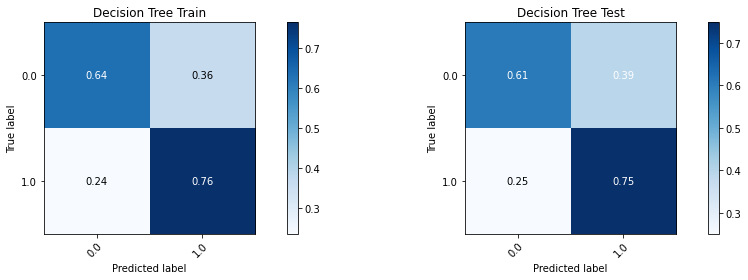

In [70]:
# Plot confusion matrix of train and test predictions
fig = plt.figure(figsize=(15, 4), facecolor='w')

confMatrix.plot(cm=confusion_matrix(y_train, y_pred_train),
                classes=y.unique(),
                title=name + ' Train',
                fig=fig,
                subplot_index=1)

confMatrix.plot(cm=confusion_matrix(y_test, y_pred),
                classes=y.unique(),
                title=name + ' Test',
                fig=fig,
                subplot_index=2)

This plot shows all the dataset splits made by the model for dividing the train dataset until the definitive classification on the leafs.

It shows the biggest advantage of decision trees: the model's interpretability, since we can go through the tree to find out which attributes lead to each label. For this specific problem, this great advantage is underused, since the classes do not have a real world interpretation.

**Important:**
Currently, this image is loaded from inside the repository for the specified seed because the *graphviz* module, necessary for the image generation, must be installed on the OS (with brew or apt-get, for example) and was not installed automatically with pip when running the file *requirements.txt*.

If you changed the seed for analyzing different results, install *graphviz* module and set the *generate_img* flag to **True** on the *tree_plot* function.

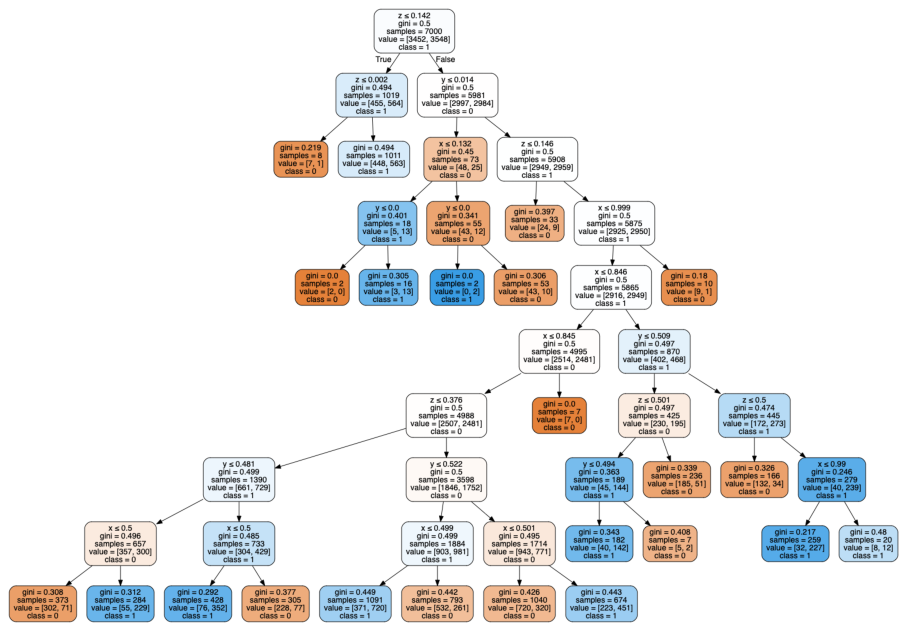

In [71]:
tree_plot = plotModule.TreePlot()
tree_plot.plot(
    classifier=tree_clf,
    img_name='images/tree.png',
    feature_labels=X.columns,
    class_labels=['0', '1'],
    generate_img=False)

### Random Forest

Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.

The low correlation between models makes it more robust than common decision tree, since uncorrelated models can produce ensemble predictions that are more accurate than any of the individual predictions.


In order to avoid overfitting, GridSearch is used for testing a acceptable range of max_depth. More parameters can be configured and are available at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) page.

In [72]:
name = "Random Forest"

# Measure start elapsed time for later comparison
start = time.time()

# Train the classifier with grid search for max_depth
grid_values = {'max_depth': range(4, 10)}
forest_clf = testClassifier(
    RandomForestClassifier(random_state=seed),
    grid_values).best_estimator_

# Predict the response using train and test data
y_pred = forest_clf.predict(X_test)
y_pred_train = forest_clf.predict(X_train)

# Measure model metrics for later comparison
end = time.time()
metrics = calculateMetrics(name, y_pred, y_test)
metrics['time'] = end - start

results = results.append(metrics, ignore_index=True)

Our Random Forest model presented the best result when compared to Logistic Regression and Decision tree, showing good performance in the detection of both classes (correcly labeling 79% of class 0 and 78% of class 1 test elements).

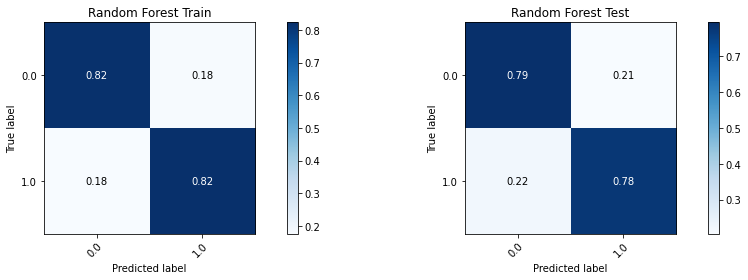

In [73]:
# Plot confusion matrix of train and test predictions
fig = plt.figure(figsize=(15, 4), facecolor='w')

confMatrix.plot(cm=confusion_matrix(y_train, y_pred_train),
                classes=y.unique(),
                title=name + ' Train',
                fig=fig,
                subplot_index=1)

confMatrix.plot(cm=confusion_matrix(y_test, y_pred),
                classes=y.unique(),
                title=name + ' Test',
                fig=fig,
                subplot_index=2)

### Support Vector Machines

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

In [74]:
name = "Support Vector Machine"

# Measure start elapsed time for later comparison
start = time.time()

# Train the classifier
grid_values = {}
svm_clf = testClassifier(
    SVC(random_state=seed, probability=True),
    grid_values).best_estimator_

# Predict the response using train and test data
y_pred = svm_clf.predict(X_test)
y_pred_train = svm_clf.predict(X_train)

# Measure model metrics for later comparison
end = time.time()
metrics = calculateMetrics(name, y_pred, y_test)
metrics['time'] = end - start

results = results.append(metrics, ignore_index=True)

Our Support Vector Machine model presented the better results when compared to Logistic Regression and Decision tree, showing good performance in the detection of both classes (correcly labeling 78% of class 0 and 75% of class 1 test elements).
However the results of Random Forest are still better.

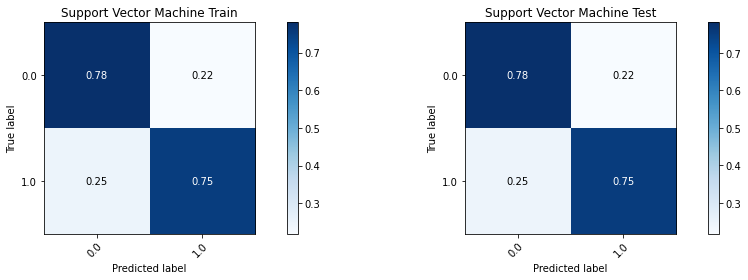

In [75]:
# Plot confusion matrix of train and test predictions
fig = plt.figure(figsize=(15, 4), facecolor='w')

confMatrix.plot(cm=confusion_matrix(y_train, y_pred_train),
                classes=y.unique(),
                title=name + ' Train',
                fig=fig,
                subplot_index=1)

confMatrix.plot(cm=confusion_matrix(y_test, y_pred),
                classes=y.unique(),
                title=name + ' Test',
                fig=fig,
                subplot_index=2)

## Results

In [76]:
results.head()

,accuracy,classifier,f1,precision,recall,time
0,0.535000,Logistic Regression,0.595300,0.521341,0.693712,0.567325
1,0.676333,Decision Tree,0.695133,0.648886,0.748479,12.298194
2,0.786333,Random Forest,0.782047,0.786594,0.777552,23.853130
3,0.767667,Support Vector Machine,0.761709,0.770401,0.753212,36.156743


### Metrics

Metrics are crucial for model selection. The choice of the metric depends on the objective we want to meet with the model.

- Accuracy is a great measure when having symmetric datasets (which is our case)
- F1 is best when having an uneven class distribution
- Recall is the one if the occurrence of false negatives is unaccepted/intolerable
- Precision is good if we want to be more confident of our true positives

Taking accuracy as the default metric we have the sequence of the best classifiers:
1. Random Forest
2. SVM
3. Decision Tree
4. Logistic Regression

In [77]:
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=results['classifier'], y=results['accuracy']),
    go.Bar(name='Precision', x=results['classifier'], y=results['precision']),
    go.Bar(name='F1', x=results['classifier'], y=results['f1']),
    go.Bar(name='Recall', x=results['classifier'], y=results['recall']),
])

fig.update_layout(title="Metrics")
fig.update_layout(barmode='group')
fig.show()

In [78]:
# Despite the best result, Random Forest is
# the model with the longest training time

fig = go.Figure(data=[
    go.Bar(name='Time', x=results['classifier'], y=results['time'])
])

fig.update_layout(
    title="Elapsed Time per model",
    yaxis_title="Time (seconds)",
)

fig.update_layout(barmode='group')
fig.show()

### Features Importance

Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other. Here we can see that Random Forest assigned similar weights for each variable while Decision Tree defined X variable as the most important one.

Usually, the importance is used for variable selection, allowing shorter training time for quite similar results. This is not our case, since the problem is simple and the dataset contains only 3 features.

In [79]:
# Creating DataFrame containing the name of
# the classifier and its importance vector

classifiers = pd.DataFrame({'classifier': ['Random Forest', 'Decision Tree']})
importances = pd.DataFrame(
    [forest_clf.feature_importances_,
     tree_clf.feature_importances_,
     logistic_regression_clf.coef_[0]],
    columns=['x', 'y', 'z']
)
classifiers = classifiers.join(importances)

# Plotting the dataframe data with different colors for each feature
fig = go.Figure(data=[
    go.Bar(name='x', x=classifiers['classifier'], y=classifiers['x']),
    go.Bar(name='y', x=classifiers['classifier'], y=classifiers['y']),
    go.Bar(name='z', x=classifiers['classifier'], y=classifiers['z'])
])

fig.update_layout(
    title="Features Importances",
    yaxis_title="Importances",
)

fig.update_layout(barmode='group')
fig.show()

### Area under the Curve (AUC)

The graph below is one of the most used to assess the quality of a model. Basically, the size under each curve is evaluated and the bigger this area, the better is the model. The AUC varies between 0 and 1, with 0.5 corresponding to a useless model, equivalent to a random prediction.

Although the other metrics indicate the occurrence of overfitting when comparing the training and test values, the AUC shows this situation more clearly. To do this, just look at the area between the training and test graphs: the larger this area, the greater the chance of overfitting.

In the graph below we can find that the Logistic Regression model has the worse result since its AUC line chart turned out to be very close to the "no skill" line.
On the other hand, the Random Forest is the one with largest area under the curve, however the big distance between the train and test graphs increases the overfitting probability.

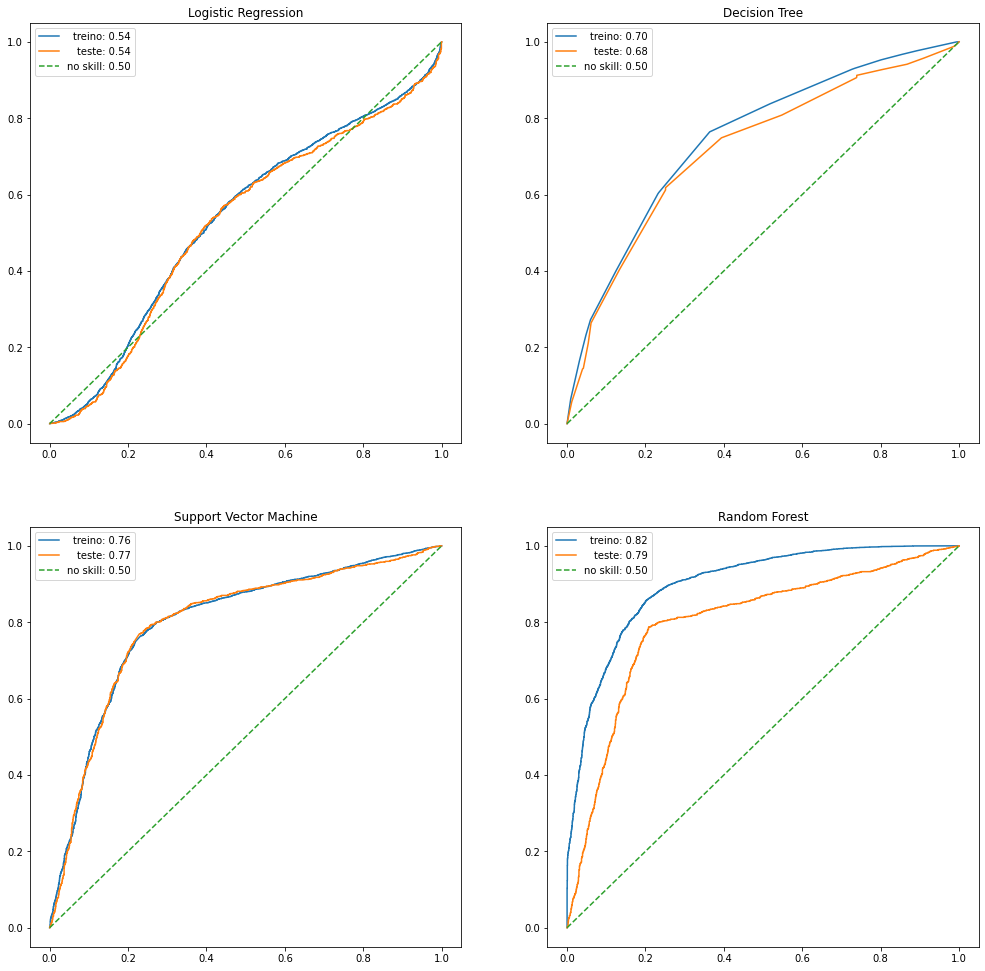

In [80]:
# Creating array with classifier, name and index
data = [
    {"classifier": logistic_regression_clf, "title": "Logistic Regression", "index": 1},
    {"classifier": tree_clf, "title": "Decision Tree", "index": 2},
    {"classifier": svm_clf, "title": "Support Vector Machine", "index": 3},
    {"classifier": forest_clf, "title": "Random Forest", "index": 4},
]

# Plotting AUC for each model
auc = plotModule.AUC()
fig = plt.figure(figsize=(17, 17))

for i in range(0, 4):
    auc.plot(
        classifier=data[i]["classifier"],
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        fig=fig,
        title=data[i]["title"],
        subplot_index=data[i]["index"])

plt.show()

### Conclusion

The Random Forest is the best model for this problem among those evaluated, presenting the higher accuracy (79% ) for the test dataset, followed by SVM with 77%. Better results can be achieved with the use of more robust techniques, such as deep learning.